# Hate Speech Classifier Model developemnt Lab

 Lab is to train **Hate-speech-classifier** model using [dataset](https://drive.google.com/file/d/1_XsweOGUzjYDbQqibSvI8M3X1hvycd8F/view?usp=drive_link)

### installing packages


In [2]:
!pip install -q gdown matplotlib seaborn wordcloud pydot nltk scikit-learn tensorflow numpy==1.26.4 wandb==0.16.6 huggingface_hub

# DATA & PREPROCESSING

## downloading data from google drive and unzipping

In [3]:
import gdown
import zipfile
import os

# Google Drive file ID
fileId = "1_XsweOGUzjYDbQqibSvI8M3X1hvycd8F"
url = f"https://drive.google.com/uc?id={fileId}"
output = "hate_speech_dataset.zip"
# downloading data
gdown.download(url, output, quiet=False)

# extracting ZIP
extract_dir = "data"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(output, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Dataset extracted to: {extract_dir}")
print("📁 Files inside:")
print(os.listdir(extract_dir))

Downloading...
From (original): https://drive.google.com/uc?id=1_XsweOGUzjYDbQqibSvI8M3X1hvycd8F
From (redirected): https://drive.google.com/uc?id=1_XsweOGUzjYDbQqibSvI8M3X1hvycd8F&confirm=t&uuid=cbd18155-3301-4352-85a6-a135dfff62f3
To: d:\Users\User\hate_speech_classification_project\lab\hate_speech_dataset.zip
100%|██████████| 47.8M/47.8M [00:02<00:00, 20.0MB/s]


✅ Dataset extracted to: data
📁 Files inside:
['HateSpeechDatasetBalanced.csv', 'labeled_data.csv']


## Data exploration and audit
### 1- Dataset

In [4]:
import pandas as pd

# Read dataset
# data_path = "/content/data/HateSpeechDatasetBalanced.csv" # running google-colab
data_path="data/HateSpeechDatasetBalanced.csv"
data = pd.read_csv(data_path)

print("✅ First 5 rows of the dataset:")
display(data.head())

print("\n\n📄 General info about data:")
print(data.info())

print("\n\n🔍 Checking for missing values:")
print(data.isnull().sum())

print("\n\n🏷️ Unique class labels:")
print(data['Label'].unique())

print("\n\n📊 Class distribution:")
print(data['Label'].value_counts(normalize=False))

print("\n\n📈 Percentage distribution:")
print(data['Label'].value_counts(normalize=True) * 100)

print("\n\nDuplications in dataset")
print(data.duplicated(subset="Content").sum())


✅ First 5 rows of the dataset:


,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1




📄 General info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726119 entries, 0 to 726118
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  726119 non-null  object
 1   Label    726119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ MB
None


🔍 Checking for missing values:
Content    0
Label      0
dtype: int64


🏷️ Unique class labels:
[1 0]


📊 Class distribution:
Label
1    364525
0    361594
Name: count, dtype: int64


📈 Percentage distribution:
Label
1    50.201826
0    49.798174
Name: proportion, dtype: float64


Duplications in dataset
26052


## Conclusion — Dataset Audit Summary
### 1. Dataset Size and Structure
*   Total rows: 726,119
*   Columns:   
          1.   Content → text column (our input features)           
          2.   Label → target variable (binary: 0 or 1)
this is a very large dataset (11 MB)  which is great to train deep learing model

### 2. Data Types and Completeness
*   No missing values

### 3. Label distribution(Balanced)
*   Label - 1 - 364,525 - 50.2%
*   Label - 0 - 361,594 - 49.8%

### Duplications
*   26.052 duplicated texts fount
That's is huge amount of data, they cause  **overfittitng** .So they will be removed





## ML-based DATA Preprocessing

In [5]:
# removing duplicated values
data = data.drop_duplicates()

# renaming columns
data.rename(columns={"Label":"label", "Content":"tweet"}, inplace=True)

## Visualization
### Class(Label) Distribution
Confirms visually that both classes (0 and 1) are balanced — just like proven numerically.

C:\Users\User\AppData\Local\Temp\ipykernel_7628\83518759.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="label", palette="viridis")


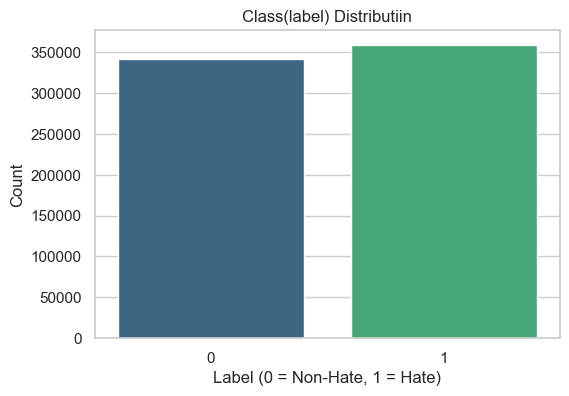

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# style
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="label", palette="viridis")

plt.title("Class(label) Distributiin")
plt.xlabel("Label (0 = Non-Hate, 1 = Hate)")
plt.ylabel("Count")
plt.show()

### Text length distribution
*   some tweets are extremely short
*   some are abnormally long



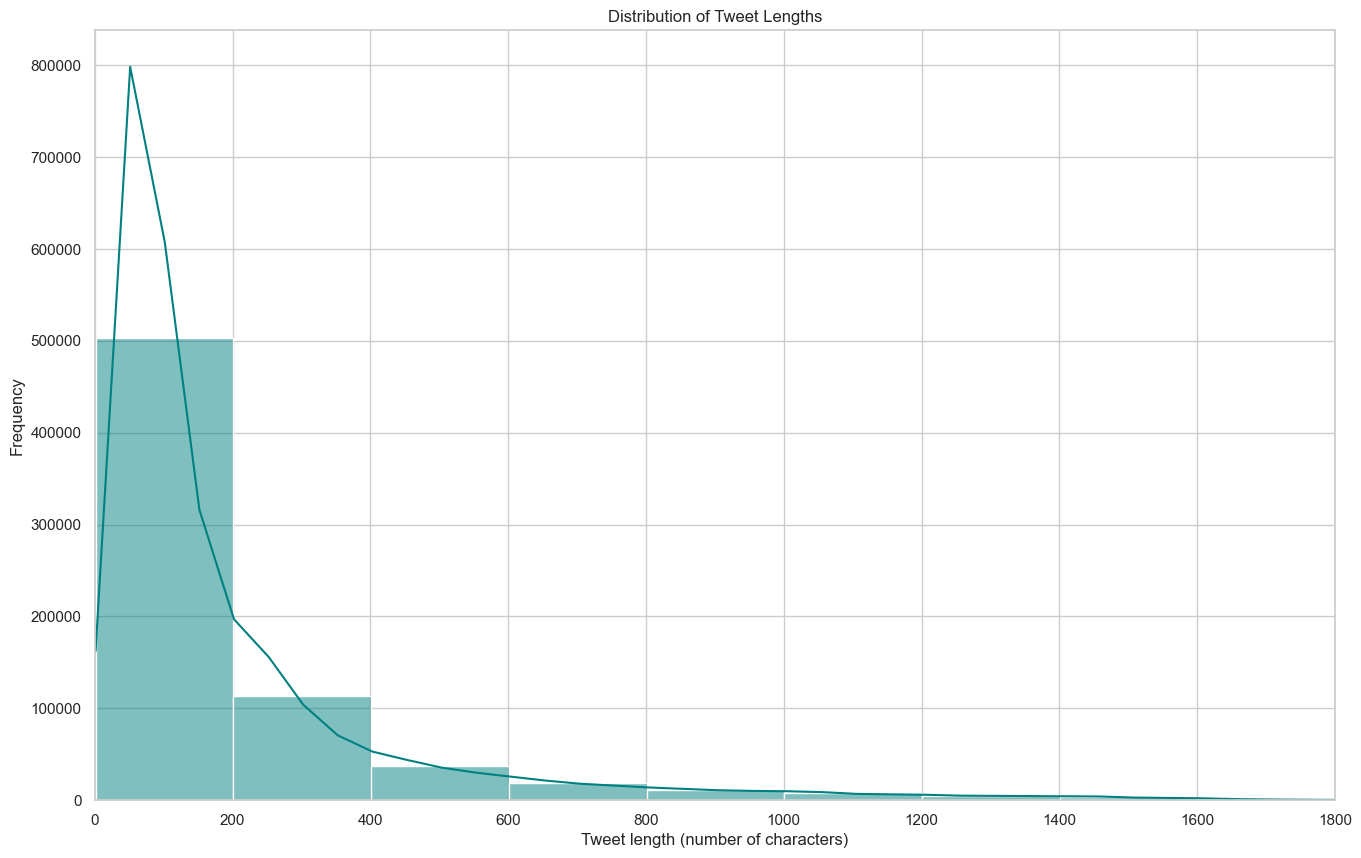

count    701073.000000
mean        195.103777
std         245.860312
min           1.000000
25%          58.000000
50%         108.000000
75%         225.000000
max        9998.000000
Name: text_length, dtype: float64


In [7]:
# Create a new column for text length
data["text_length"] = data["tweet"].astype(str).apply(len)

plt.figure(figsize=(16,10))
sns.histplot(data["text_length"], bins=50, kde=True, color='teal')

plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet length (number of characters)")
plt.xlim(0, 1800)
plt.ylabel("Frequency")
plt.show()

# Optional: descriptive stats
print(data["text_length"].describe())

# dropping the added column
data.drop(['text_length'],axis=1, inplace=True)

### WordCloud for Each Class
*   the most frequent words in each class
*   helps detect data



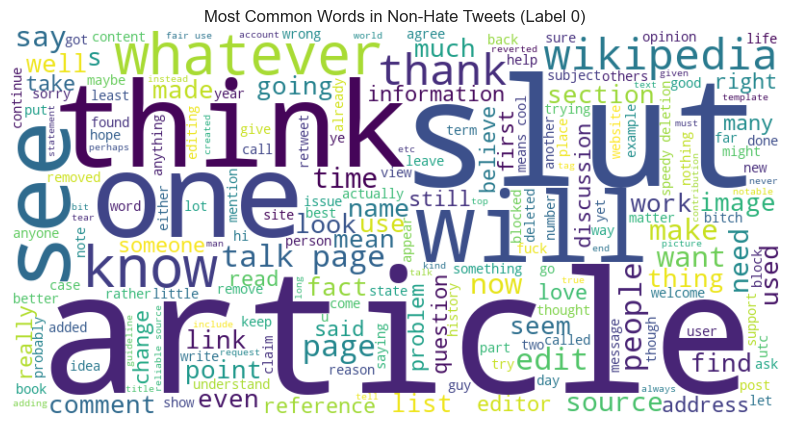

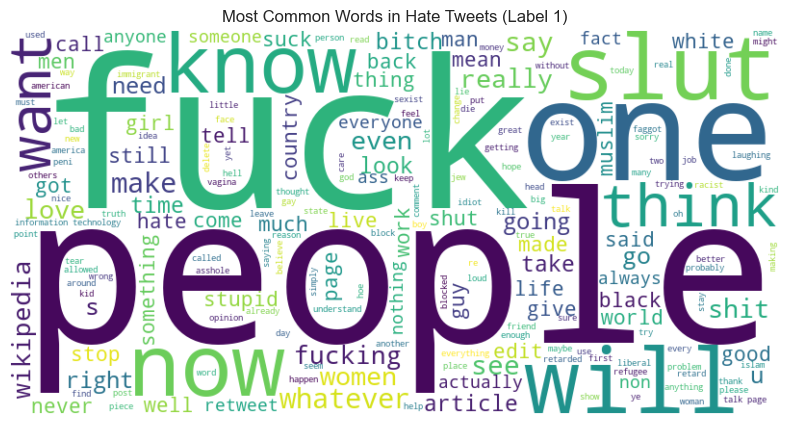

In [8]:
from wordcloud import WordCloud

# WordCloud for label = 0
text_nonhate = " ".join(data[data["label"] == 0]["tweet"].astype(str))
wc_nonhate = WordCloud(width=800, height=400, background_color="white").generate(text_nonhate)

plt.figure(figsize=(10,5))
plt.imshow(wc_nonhate, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Non-Hate Tweets (Label 0)")
plt.show()

# WordCloud for label = 1
text_hate = " ".join(data[data["label"] == 1]["tweet"].astype(str))
wc_hate = WordCloud(width=800, height=400, background_color="white").generate(text_hate)

plt.figure(figsize=(10,5))
plt.imshow(wc_hate, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Hate Tweets (Label 1)")
plt.show()


### 2-dataset


In [9]:
#reading data
# data_2 = pd.read_csv("/content/data/labeled_data.csv") running in google colab
data_2=pd.read_csv("data/labeled_data.csv")

print("✅ First 5 rows of Dataset 2:")
display(data_2.head())

print("\n\n📄 General info:")
print(data_2.info())

print("\n\n🔍 Missing values:")
print(data_2.isnull().sum())

print("\n\n🏷️ Unique labels:")
print(data_2["class"].unique())

print("\n\n📊 Class distribution:")
print(data_2['class'].value_counts(normalize=False))

print("\n\n📈 Percentage distribution:")
print(data_2['class'].value_counts(normalize=True) * 100)

print("\n\nDuplications in dataset")
print(data_2.duplicated(subset="tweet").sum())

✅ First 5 rows of Dataset 2:


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...




📄 General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB
None


🔍 Missing values:
Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64


🏷️ Unique labels:
[2 1 0]


📊 Class distribution:
class
1    19190
2     4163
0     1430
Name: count, dtype: int64


📈 Percentage distribution:
class
1    77.432111
2    16.797805
0   

## Conclusion — Dataset Audit Summary
### 1. Dataset Size and Structure
*   Total row: 24 793
*   Columns:    
            1. tweet --> text column (input feature)      
            2. class --> target column  
            3. the rest of columns(count, hate_speech, offensive_language, neither) isn't required

### 2. Missing values
all columns have 0 missing values

### 3. Label Distribution
*   class 1 --> 19 190 --> hate speech
*   class 2 --> 4 163 --> no hate
*   class 0 --> 1 430 --> hate speech

### 4. Duplicates
0 duplicates







## ML-based DATA Preprocessing for dataset -2

In [10]:
# dropping unnecessary columns
data_2.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'], axis=1, inplace=True)

# relabeling the classes
data_2.loc[data_2['class'] == 0, 'class'] = 1  # hate → 1
data_2.loc[data_2['class'] == 2, 'class'] = 0  # neither → 0

# reaning class column with label
data_2.rename(columns={"class":"label"}, inplace=True)

## Visualization for dataset 2
### Class(Label) Distribution
this dataset is not balanced, but it is not problem because both datasets will be combined, the first dataset's is bigger that second.The second dataset's distribution is small

C:\Users\User\AppData\Local\Temp\ipykernel_7628\2516787702.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_2, x="label", palette="viridis")


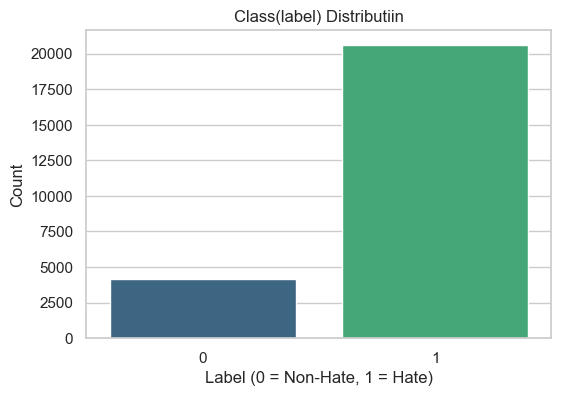

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# style
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(data=data_2, x="label", palette="viridis")

plt.title("Class(label) Distributiin")
plt.xlabel("Label (0 = Non-Hate, 1 = Hate)")
plt.ylabel("Count")
plt.show()

### Text length distribution
*   some tweets are extremely short
*   some are abnormally long


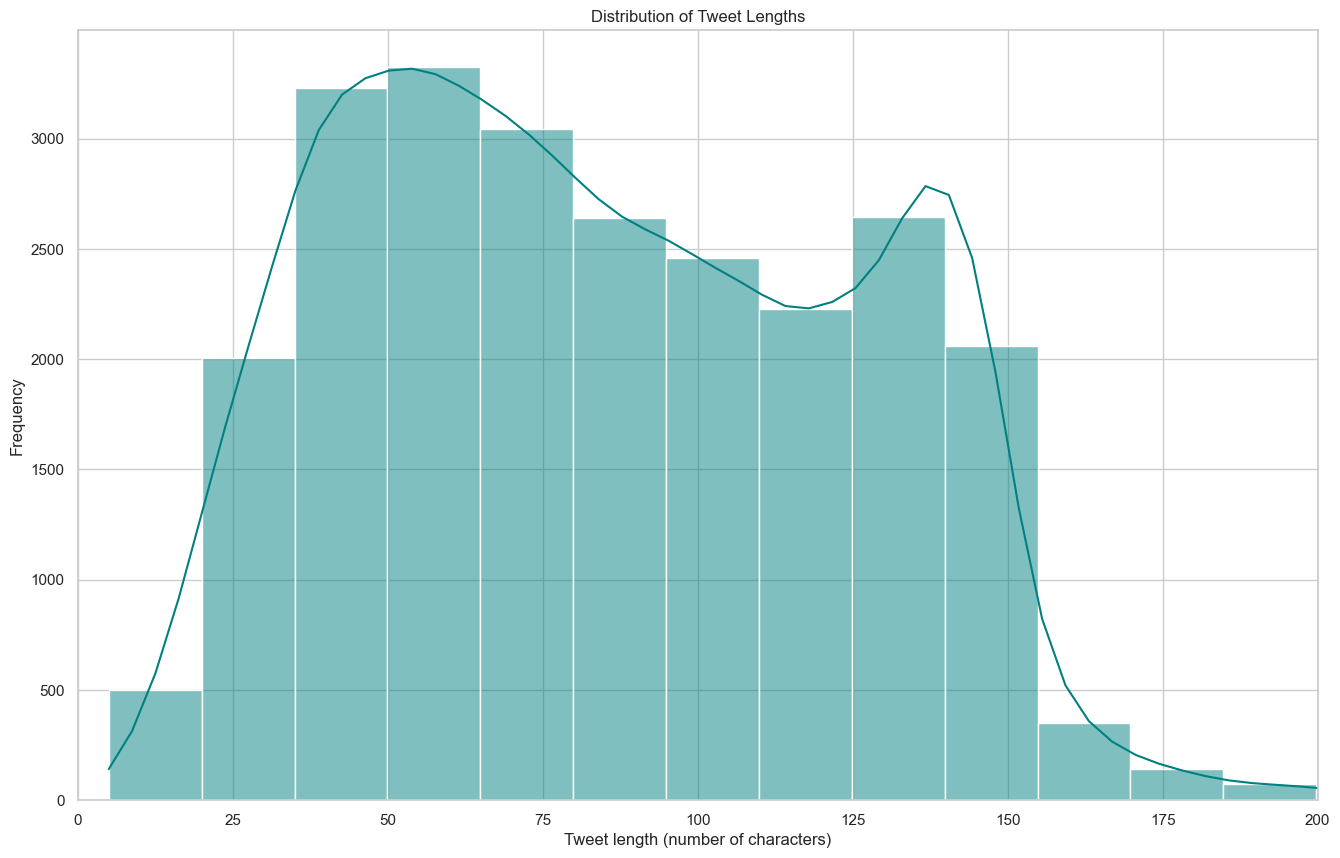

count    24783.000000
mean        85.436065
std         41.548238
min          5.000000
25%         52.000000
50%         81.000000
75%        119.000000
max        754.000000
Name: text_length, dtype: float64


In [12]:
# Create a new column for text length
data_2["text_length"] = data_2["tweet"].astype(str).apply(len)

plt.figure(figsize=(16,10))
sns.histplot(data_2["text_length"], bins=50, kde=True, color='teal')

plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet length (number of characters)")
plt.xlim(0, 200)
plt.ylabel("Frequency")
plt.show()

print(data_2["text_length"].describe())

# dropping the added column
data_2.drop(['text_length'],axis=1, inplace=True)

### WordCloud for Each Class
*   the most frequent words in each class
*   helps detect data


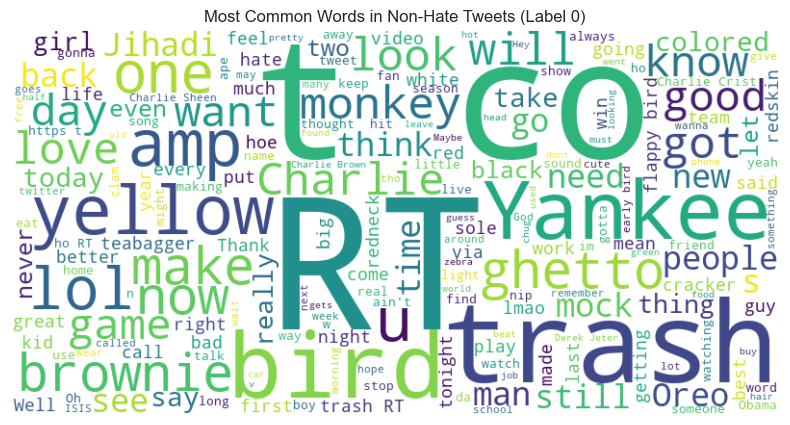

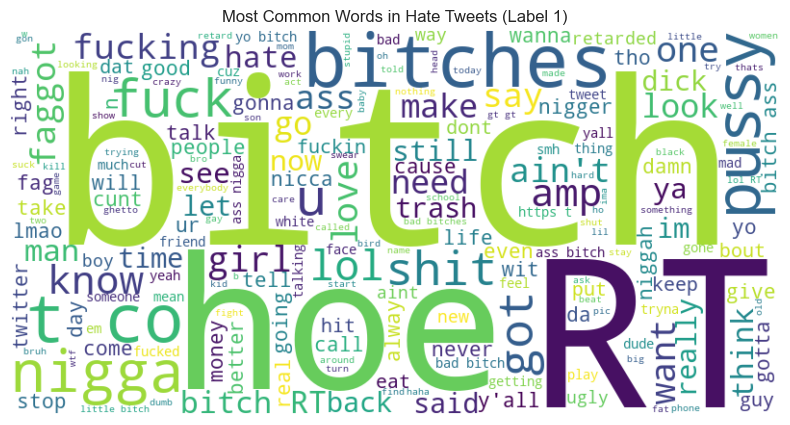

In [13]:
from wordcloud import WordCloud

# WordCloud for label = 0
text_nonhate = " ".join(data_2[data_2["label"] == 0]["tweet"].astype(str))
wc_nonhate = WordCloud(width=800, height=400, background_color="white").generate(text_nonhate)

plt.figure(figsize=(10,5))
plt.imshow(wc_nonhate, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Non-Hate Tweets (Label 0)")
plt.show()

# WordCloud for label = 1
text_hate = " ".join(data_2[data_2["label"] == 1]["tweet"].astype(str))
wc_hate = WordCloud(width=800, height=400, background_color="white").generate(text_hate)

plt.figure(figsize=(10,5))
plt.imshow(wc_hate, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Hate Tweets (Label 1)")
plt.show()

### Combining two datasets [data_1 and data_2]

In [14]:
data = pd.concat([data, data_2])
data.head()

,tweet,label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [15]:
print("✅ Combined dataset shape:", data.shape)
print("✅ Columns:", data.columns.tolist())


✅ Combined dataset shape: (725856, 2)
✅ Columns: ['tweet', 'label']


some tweets might be overlap between datasets,
removing them

In [16]:
before = data.shape[0]
data = data.drop_duplicates(subset='tweet')
after = data.shape[0]

print(f"🧹 Removed {before - after} duplicate tweets after merging")
print(f"✅ Final dataset size: {after}")


🧹 Removed 1138 duplicate tweets after merging
✅ Final dataset size: 724718


In [17]:
print("\n🏷️ Combined label distribution:")
print(data['label'].value_counts())

print("\n📈 Percentage distribution:")
print(data['label'].value_counts(normalize=True) * 100)



🏷️ Combined label distribution:
label
1    379072
0    345646
Name: count, dtype: int64

📈 Percentage distribution:
label
1    52.306138
0    47.693862
Name: proportion, dtype: float64


## NLP-based Data Preprocessing
### data cleaning → tokenization → stop-word removal → stemming

In [18]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# downloading NLTK's stopwords corpus
nltk.download('stopwords')
# downloading NLTK's tokenizers
nltk.download('punkt')


stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_tweet(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags (keep words)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    # Remove numbers and punctuation
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    tokens = text.split()
    # Remove stopwords and apply stemming
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    # Join tokens back to text
    return " ".join(tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
data['tweet'] = data['tweet'].apply(clean_tweet)

## Visualization
### Class Distribution (Balance check)

C:\Users\User\AppData\Local\Temp\ipykernel_7628\1337725872.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='viridis')


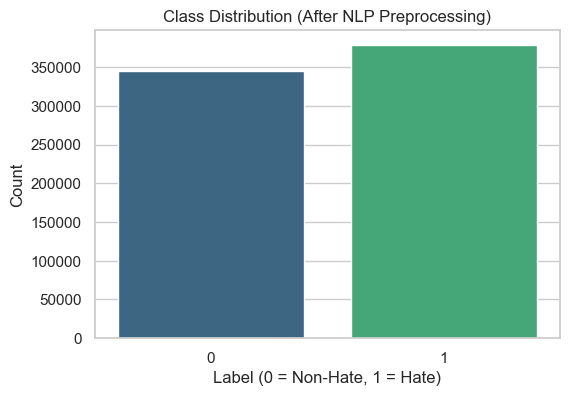

label
1    52.306138
0    47.693862
Name: proportion, dtype: float64


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data, palette='viridis')

plt.title("Class Distribution (After NLP Preprocessing)")
plt.xlabel("Label (0 = Non-Hate, 1 = Hate)")
plt.ylabel("Count")
plt.show()

print(data['label'].value_counts(normalize=True) * 100)


### Text length distribution

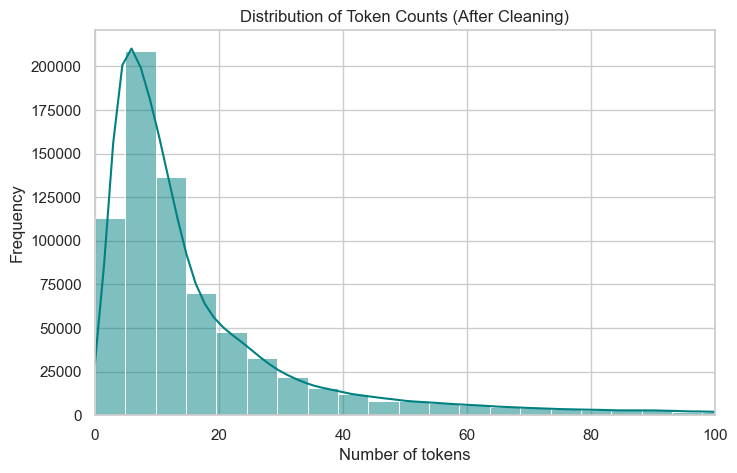

count    724718.000000
mean         18.325694
std          22.115515
min           0.000000
50%          11.000000
90%          42.000000
95%          64.000000
99%         116.000000
max         294.000000
Name: token_count, dtype: float64


In [21]:
data['token_count'] = data['tweet'].str.split().apply(len)

plt.figure(figsize=(8,5))
sns.histplot(data['token_count'], bins=60, kde=True, color='teal')

plt.title("Distribution of Token Counts (After Cleaning)")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")

# Zoom in to the useful range (e.g., 0–100)
plt.xlim(0, 100)
plt.show()

print(data['token_count'].describe(percentiles=[.5, .9, .95, .99]))
data.drop(['token_count'], axis=1, inplace=True)


### Most Common Words by Class

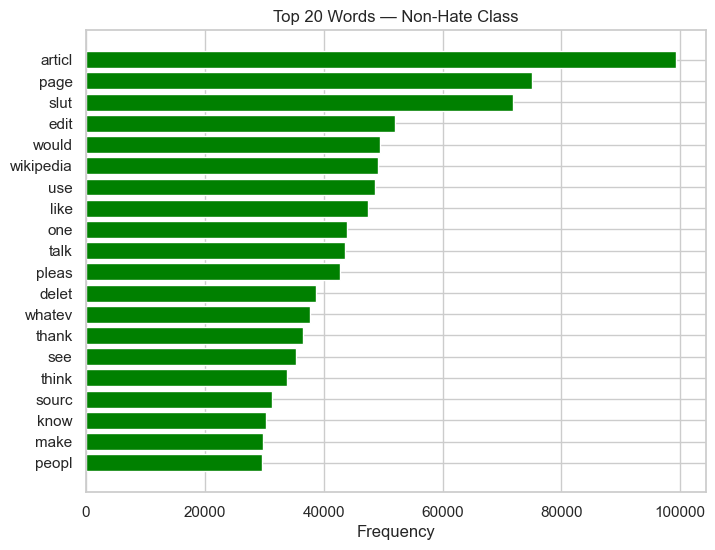

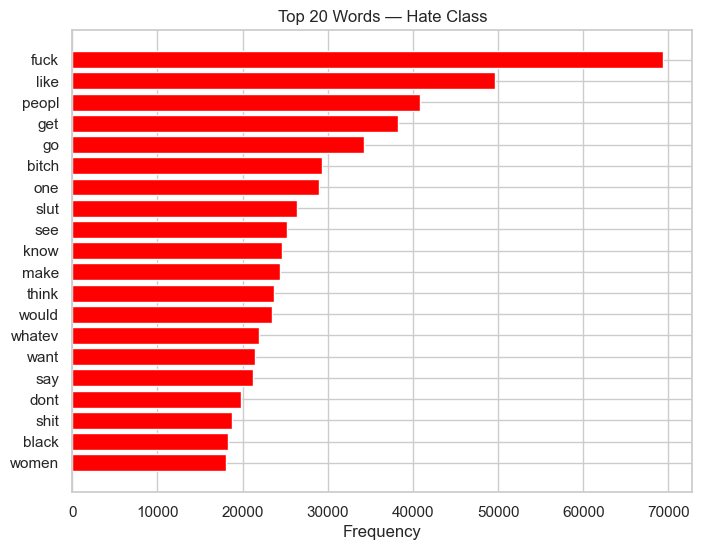

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def top_words(texts, n=20):
    vec = CountVectorizer().fit(texts)
    bag = vec.transform(texts)
    freqs = np.ravel(bag.sum(axis=0))
    words = np.array(vec.get_feature_names_out())
    idx = np.argsort(freqs)[::-1][:n]
    return words[idx], freqs[idx]

# Separate hate and non-hate
hate_texts = data[data['label']==1]['tweet']
non_hate_texts = data[data['label']==0]['tweet']

hate_words, hate_freq = top_words(hate_texts)
nonhate_words, nonhate_freq = top_words(non_hate_texts)

# Plot
plt.figure(figsize=(8,6))
plt.barh(nonhate_words[::-1], nonhate_freq[::-1], color='green')
plt.title("Top 20 Words — Non-Hate Class")
plt.xlabel("Frequency")
plt.show()

plt.figure(figsize=(8,6))
plt.barh(hate_words[::-1], hate_freq[::-1], color='red')
plt.title("Top 20 Words — Hate Class")
plt.xlabel("Frequency")
plt.show()


### Word counds for each class

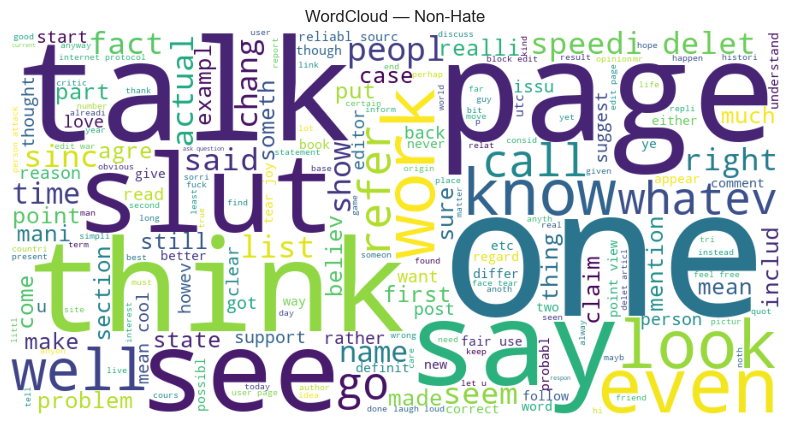

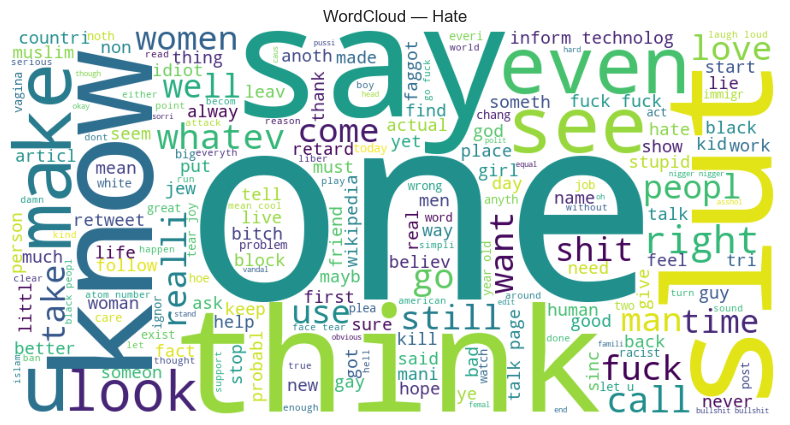

In [23]:
from wordcloud import WordCloud

text_0 = " ".join(non_hate_texts)
text_1 = " ".join(hate_texts)

plt.figure(figsize=(10,5))
plt.imshow(WordCloud(width=900, height=450, background_color="white").generate(text_0))
plt.axis("off")
plt.title("WordCloud — Non-Hate")
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(WordCloud(width=900, height=450, background_color="white").generate(text_1))
plt.axis("off")
plt.title("WordCloud — Hate")
plt.show()


## Splitting data into Train / Validation / Test
✅ Train set **80%** --> model learning   
✅ Validation set **10%** --> hyperparameter tuning / model selection   
✅ Test set **10%** --> final evaluation

In [24]:
from sklearn.model_selection import train_test_split

# sperate features and Label
X = data['tweet']
y = data['label']

# split ---> train 80% and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # ensures class balance
)

# Split split ----> Validation 10% and tets 10%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,      # 50% of 20% = 10%
    random_state=42,
    stratify=y_temp# ensures class balance
)

# confirm the sizes
print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 579774 samples
Validation set: 72472 samples
Test set: 72472 samples


In [25]:
print("\nClass distribution:")
for name, labels in zip(["Train", "Validation", "Test"], [y_train, y_val, y_test]):
    dist = labels.value_counts(normalize=True) * 100
    print(f"{name} → 0: {dist[0]:.2f}% | 1: {dist[1]:.2f}%")



Class distribution:
Train → 0: 47.69% | 1: 52.31%
Validation → 0: 47.69% | 1: 52.31%
Test → 0: 47.69% | 1: 52.31%


# Tokenization

In [26]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# vocabuary cap based on data scale
max_words = 200000
# fit tokenizer on Train dataset
tokenizer = Tokenizer(num_words=max_words,
                      oov_token="<OOV>",
                      lower=False,
                      split=' ',
                      )
tokenizer.fit_on_texts(X_train)

vocab_size_total = len(tokenizer.word_index)+1 # 1 for padding
vocab_cap_offective = min(max_words, vocab_size_total)
print(f"Total vocab found: {vocab_size_total} | Using up to : {vocab_cap_offective:}")


# pratical sequnce length from train data
train_seqs_preview = tokenizer.texts_to_sequences(X_train)
train_token_length = np.array([len(s) for s in train_seqs_preview])
p95 = int(np.percentile(train_token_length, 95))
p99 = int(np.percentile(train_token_length, 99))
max_len = max(16, min(300, p95))
print(f"\n\nToken length percentiles --> p95={p95}, p99={p99} | Using max_len={max_len}")

# vectoring all splits(pad/truncate)
def vectorize(texts):
  seqs = tokenizer.texts_to_sequences(texts)
  mat = pad_sequences(seqs, maxlen=max_len, padding="post", truncating="post")
  return seqs, mat
train_seqs, X_train_mat = vectorize(X_train)
val_seqs,   X_val_mat   = vectorize(X_val)
test_seqs,  X_test_mat  = vectorize(X_test)
print(f"\n\nShapes → train {X_train_mat.shape}, val {X_val_mat.shape}, test {X_test_mat.shape}")

## OOV diagnostics
oov_id = tokenizer.word_index.get("<OOV>",1)
def oov_rate(seqs, oov_token_id=oov_id):
    total = sum(len(s) for s in seqs)
    if total == 0:
        return 0.0
    oov = sum(np.sum(np.array(s) == oov_token_id) for s in seqs)
    return 100.0 * oov / total

print(f"\n\nOOV rate (train): {oov_rate(train_seqs):.2f}%")
print(f"OOV rate (val)  : {oov_rate(val_seqs):.2f}%")
print(f"OOV rate (test) : {oov_rate(test_seqs):.2f}%")

sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")


Total vocab found: 99963 | Using up to : 99963


Token length percentiles --> p95=64, p99=116 | Using max_len=64


Shapes → train (579774, 64), val (72472, 64), test (72472, 64)


OOV rate (train): 0.00%
OOV rate (val)  : 0.39%
OOV rate (test) : 0.41%


## Model architecure
### BiGRU + Attention model

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.keras.backend.clear_session()

# attention pooling
class AttentionPooling1D(layers.Layer):
    def __init__(self, units=128):
        super().__init__()
        self.supports_masking = True
        self.dense = layers.Dense(units, activation="tanh")
        self.score = layers.Dense(1, use_bias=False)

    def call(self, x, mask=None):
        e = tf.squeeze(self.score(self.dense(x)), -1)  # [B,T]
        if mask is not None:
            e = e + (1.0 - tf.cast(mask, e.dtype)) * (-1e9)
        a = tf.nn.softmax(e, axis=1)
        a = tf.expand_dims(a, -1)
        return tf.reduce_sum(a * x, axis=1)
    def compute_mask(self, inputs, mask=None):
        return None

# --- hyperparams ---
vocab_size = min(200_000, len(tokenizer.word_index) + 1)
seq_len    = max_len
embed_dim  = 128
rnn_units  = 128
drop_rate  = 0.3

# --- model ---
inputs = keras.Input(shape=(seq_len,), dtype="int32")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inputs)
x = layers.SpatialDropout1D(0.2)(x)
x = layers.Bidirectional(layers.GRU(rnn_units, return_sequences=True, recurrent_dropout=0.1))(x)
# attention pooling
attn = AttentionPooling1D(128)(x)
# classifier header
z = layers.Dropout(drop_rate)(attn)
z = layers.Dense(128, activation="relu")(z)
z = layers.Dropout(drop_rate)(z)
outputs = layers.Dense(1, activation="sigmoid")(z)
model = keras.Model(inputs, outputs)

#compiling the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(name="AUC-PR", curve="PR"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        "accuracy",
    ],
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64, 128)   │ 12,795,264 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 64, 128)   │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 64)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64, 256)   │    198,144 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_pooling1d │ (None, 256)       │     33,024 │ bidirectional[0]… │
│ (AttentionPooling1… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ attention_poolin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,059,457 (49.82 MB)

 Trainable params: 13,059,457 (49.82 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model_architecture.png", show_shapes=True, dpi=160)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


### Model checkpoint + early stop

In [29]:
from tensorflow import keras

ckpt_path = "best_attention_bigru.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=ckpt_path,
        monitor="val_AUC-PR",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_AUC-PR",
        mode="max",
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_AUC-PR",
        mode="max",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
]

### Logging Training to WanDB

In [30]:
import wandb
from tensorflow import keras

# 1) login + init
wandb.login()
wandb.init(
    project="hate-speech-classifer",
    name="AttentionBiGRU-model",
    config={
        "vocab_size": int(min(200_000, len(tokenizer.word_index)+1)),
        "max_len": int(max_len),
        "embed_dim": 128,
        "rnn_units": 128,
        "dropout": 0.3,
        "batch_size": 128,
        "lr": 3e-4,
        "architecture": "BiGRU + AttentionPooling",
        "monitor": "val_AUC-PR",
    },
)
# 3) remove ANY WandbCallback if present (safety)
callbacks = [cb for cb in callbacks if cb.__class__.__name__ != "WandbCallback"]

# 4) minimal safe logger
class WBLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs:
            wandb.log({**{k: float(v) for k, v in logs.items()}, "epoch": int(epoch)})

callbacks.append(WBLogger())


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: diyorarti (diyor). Use `wandb login --relogin` to force relogin


### training

Model is trained in GOOGLE Colab GPU

In [31]:
# history = model.fit(
#     X_train_mat,
#     y_train,
#     validation_data=(X_val_mat, y_val),
#     batch_size=wandb.config.batch_size,
#     epochs=10,
#     callbacks=callbacks,
#     verbose=1
# )

### Evaluation
the cell code can be run after model training

In [32]:
# import numpy as np
# from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix, classification_report

# # 1) get validation probabilities
# val_probs = model.predict(X_val_mat, batch_size=1024).ravel()

# # 2) sweep thresholds and pick the best by macro-F1
# ts = np.linspace(0.1, 0.9, 81)  # 0.1 .. 0.9 step 0.01
# best_t, best_f1 = 0.5, -1.0
# for t in ts:
#     preds = (val_probs >= t).astype(int)
#     f1 = f1_score(y_val, preds, average="macro")
#     if f1 > best_f1:
#         best_f1, best_t = f1, t

# print(f"✅ Best threshold on validation: {best_t:.3f} | Macro-F1: {best_f1:.4f}")

# # 3) detailed metrics at the best threshold
# val_preds = (val_probs >= best_t).astype(int)
# prec, rec, f1, supp = precision_recall_fscore_support(y_val, val_preds, average=None, labels=[0,1], zero_division=0)
# print("\nPer-class metrics (label 0, label 1):")
# print(f"Precision: {prec}")
# print(f"Recall   : {rec}")
# print(f"F1       : {f1}")

# print("\nClassification report:")
# print(classification_report(y_val, val_preds, digits=4))

# print("Confusion matrix:\n", confusion_matrix(y_val, val_preds))


In [33]:
# from sklearn.metrics import classification_report

# # Get predictions
# y_pred_probs = model.predict(X_test_mat, verbose=0).ravel()
# y_pred = (y_pred_probs >= 0.5).astype(int)

# print(classification_report(y_test, y_pred, digits=4))


In [34]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# cm = confusion_matrix(y_test, y_pred)
# ConfusionMatrixDisplay(cm).plot(cmap="Blues")
# plt.show()


In [35]:
# plt.plot(history.history['accuracy'], label='train acc')
# plt.plot(history.history['val_accuracy'], label='val acc')
# plt.legend()
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Training vs Validation Accuracy")
# plt.show()


# MODEL Performance
### The BiGRU + Attention model achieved 85.7% accuracy on the test set, with a Precision of 0.87 and Recall of 0.89 for the hate-speech class.
The model shows strong ability to correctly identify hate speech, with a slightly higher recall than precision — meaning it detects most hateful content while allowing a few false positives.

Overall, the model generalizes well and performs robustly for binary text classification on the hate-speech dataset.

# Uploading Trained Model to HuggingFace Hub

In [36]:
# from huggingface_hub import login, whoami, create_repo, upload_folder
# import os, json

# # 1️⃣ login
# login()

# # 2️⃣ create a local folder for model artifacts
# os.makedirs("hate_speech_Classifier_model", exist_ok=True)

# # 3️⃣ save model (both Keras and SavedModel)
# model.save("hate_speech_Classifier_model/model.keras")
# model.export("hate_speech_Classifier_model/saved_model")

# # 4️⃣ save tokenizer and config
# with open("hate_speech_Classifier_model/tokenizer.json", "w") as f:
#     f.write(tokenizer.to_json())

# with open("hate_speech_Classifier_model/tokenizer_config.json", "w") as f:
#     json.dump({"max_len": int(max_len)}, f, indent=2)

# # 5️⃣ minimal README.md
# readme = f"""# Hate Speech Classifier — Attention BiGRU (Keras)

# **Input:** raw text
# **Output:** binary label (0 = non-hate, 1 = hate) + probability

# - seq_len: {int(max_len)}
# - vocab_size: {min(200_000, len(tokenizer.word_index)+1)}
# - architecture: Embedding → BiGRU → AttentionPooling → Dense

# This repo contains:
# - `model.keras` (trained Keras model)
# - `saved_model/` (SavedModel export)
# - `tokenizer.json`, `tokenizer_config.json`
# """
# with open("hate_speech_Classifier_model/README.md", "w") as f:
#     f.write(readme)

# # 6️⃣ requirements file (these will be installed automatically by HF inference)
# with open("hate_speech_Classifier_model/requirements.txt", "w") as f:
#     f.write("tensorflow>=2.15\nnumpy==1.26.4\nscikit-learn\nnltk\nhuggingface_hub\n")

# # 7️⃣ create repo and upload
# owner = whoami()["name"]
# repo_name = "hate-speech-attn-bigru-keras"
# repo_id = f"{owner}/{repo_name}"

# create_repo(repo_id, private=True, exist_ok=True)

# upload_folder(
#     repo_id=repo_id,
#     repo_type="model",
#     folder_path="hate_speech_Classifier_model",
#     path_in_repo=".",   # upload everything to the repo root
# )

# print("✅ Uploaded to:", repo_id)


In [37]:
# from huggingface_hub import whoami, upload_file
# import textwrap, json

# owner = whoami()["name"]
# repo_name = "hate-speech-attn-bigru-keras"
# repo_id = f"{owner}/{repo_name}"

# inference_py = textwrap.dedent(r"""
# import json
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.preprocessing.text import tokenizer_from_json
# from tensorflow import keras
# from tensorflow.keras import layers

# # --- custom attention layer (same as training) ---
# class AttentionPooling1D(layers.Layer):
#     def __init__(self, units=128, **kwargs):
#         super().__init__(**kwargs)
#         self.supports_masking = True
#         self.dense = layers.Dense(units, activation="tanh")
#         self.score = layers.Dense(1, use_bias=False)
#     def call(self, x, mask=None):
#         e = tf.squeeze(self.score(self.dense(x)), -1)  # [B,T]
#         if mask is not None:
#             e = e + (1.0 - tf.cast(mask, e.dtype)) * (-1e9)
#         a = tf.nn.softmax(e, axis=1)                   # [B,T]
#         a = tf.expand_dims(a, -1)                      # [B,T,1]
#         return tf.reduce_sum(a * x, axis=1)            # [B,D]
#     def get_config(self):
#         cfg = super().get_config()
#         cfg.update({"units": 128})
#         return cfg

# # --- load artifacts 
# with open("tokenizer.json", "r", encoding="utf-8") as f:
#     TOKENIZER = tokenizer_from_json(f.read())

# with open("tokenizer_config.json", "r", encoding="utf-8") as f:
#     CFG = json.load(f)

# MAX_LEN = int(CFG.get("max_len", 64))

# # Prefer the Keras file; if missing, fall back to SavedModel
# try:
#     MODEL = load_model("model.keras", custom_objects={"AttentionPooling1D": AttentionPooling1D})
# except Exception:
#     MODEL = tf.keras.models.load_model("saved_model", custom_objects={"AttentionPooling1D": AttentionPooling1D})

# def _preprocess(texts):
#     if isinstance(texts, str):
#         texts = [texts]
#     seqs = TOKENIZER.texts_to_sequences(texts)
#     mat = pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")
#     return mat, texts

# def _predict(texts, threshold=0.5):
#     X, raw = _preprocess(texts)
#     probs = MODEL.predict(X, verbose=0).ravel().tolist()
#     preds = [int(p >= threshold) for p in probs]
#     return {"predictions": preds, "probabilities": probs}

# # HF Inference Endpoints entrypoint:
# # receives a dict like {"inputs": "..."} or {"inputs": ["...", "..."]}.
# def __call__(self, data: dict):
#     texts = data.get("inputs", "")
#     threshold = float(data.get("parameters", {}).get("threshold", 0.5)) if isinstance(data.get("parameters", {}), dict) else 0.5
#     return _predict(texts, threshold=threshold)
# """).lstrip()

# # write locally then upload
# with open("inference.py", "w", encoding="utf-8") as f:
#     f.write(inference_py)

# upload_file(
#     path_or_fileobj="inference.py",
#     path_in_repo="inference.py",
#     repo_id=repo_id,
#     repo_type="model",
# )

# print("✅ Uploaded inference.py to", repo_id)


### checking HF-HUb uploaded model

In [38]:
from huggingface_hub import hf_hub_download
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json, re

# 🔹 Replace with
repo_id = "diyorarti/hate-speech-attn-bigru-keras"

# 1️⃣ Download model and tokenizer files from the Hub
model_path = hf_hub_download(repo_id=repo_id, filename="model.keras")
tokenizer_path = hf_hub_download(repo_id=repo_id, filename="tokenizer.json")
config_path = hf_hub_download(repo_id=repo_id, filename="tokenizer_config.json")

# 2️⃣ Define custom layer (must match training)
from tensorflow.keras import layers

class AttentionPooling1D(layers.Layer):
    def __init__(self, units=128, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.dense = layers.Dense(units, activation="tanh")
        self.score = layers.Dense(1, use_bias=False)
    def call(self, x, mask=None):
        e = tf.squeeze(self.score(self.dense(x)), -1)
        if mask is not None:
            e = e + (1.0 - tf.cast(mask, e.dtype)) * (-1e9)
        a = tf.nn.softmax(e, axis=1)
        a = tf.expand_dims(a, -1)
        return tf.reduce_sum(a * x, axis=1)
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"units": 128})
        return cfg

# 3️⃣ Load model and tokenizer
model = load_model(model_path, custom_objects={"AttentionPooling1D": AttentionPooling1D})

with open(tokenizer_path, "r", encoding="utf-8") as f:
    tokenizer = tokenizer_from_json(f.read())

with open(config_path, "r", encoding="utf-8") as f:
    cfg = json.load(f)
MAX_LEN = int(cfg["max_len"])

# 4️⃣ Define preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

def predict_text(text):
    clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([clean])
    X = pad_sequences(seq, maxlen=MAX_LEN, padding="post")
    prob = model.predict(X, verbose=0)[0][0]
    label = "hate" if prob < 0.5 else "not hate"
    return {"text": text, "cleaned": clean, "probability": float(prob), "label": label}

# 5️⃣ Test
print(predict_text("I hate you so much"))
print(predict_text("You are a wonderful human being"))


d:\Anaconda\envs\hatespeechclassiferAPI\lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'attention_pooling1d_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


{'text': 'I hate you so much', 'cleaned': 'i hate you so much', 'probability': 0.3342578113079071, 'label': 'hate'}
{'text': 'You are a wonderful human being', 'cleaned': 'you are a wonderful human being', 'probability': 0.8751886487007141, 'label': 'not hate'}
